In [1]:
%matplotlib inline

import xarray as xr
import intake
import util 
import pprint 
import dask
import gsw
import matplotlib.pyplot as plt
import numpy as np
nm = 12

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

In [3]:
cat = col.search(experiment_id=['historical'],table_id=['Omon'],institution_id=['NCAR'],variable_id=['thetao','so'],member_id='r1i1p1f1',
                grid_label='gn')

In [4]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [5]:
for i in dset_dict:
    dset_dict[i]= dset_dict[i].sel(time=slice('1986','2005')).groupby('time.month').mean().sel(month=8)
    
    # calculate cthetao and add to ds
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, dset_dict[i].so, dset_dict[i].thetao, dask='parallelized',
                                         output_dtypes=[float,]).rename('cthetao').to_dataset()     
    dset_dict[i] = xr.merge([dset_dict[i],cthetao])
    
    # calculate sigma0 and add to ds
    sigma0 = xr.apply_ufunc(gsw.density.sigma0,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()                                                                          
    dset_dict[i] = xr.merge([dset_dict[i],sigma0])
    
    # calculate sigma2 and add to ds
    sigma2=xr.apply_ufunc(gsw.density.sigma2,dset_dict[i].so, dset_dict[i].cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    dset_dict[i] = xr.merge([sigma2, dset_dict[i]])
    
    
    # Interpolate potential density and select 10 m
    #surf_dens = dset_dict[i].sigma0.interp(lev=np.linspace(0,20,21)).sel(lev = 10)
    #surf_dens.plot(); plt.show(); plt.close()
    
    # Calculate mixed layer depth based on density difference from 10m
    #dens_diff = dset_dict[i].sigma0 - surf_dens
    #dens_diff = dens_diff.where(dens_diff > 0.03)
    #mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])
    
    # plot for sanity check
    #mld.mld.plot(); plt.show(); plt.close()
    
    # get variables at bottom
    test = dset_dict[i].sigma0 + dset_dict[i].lev
    bottom_depth = dset_dict[i].lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_sigma2 = dset_dict[i].sigma2.where(test == test.max(['lev'])).max(dim='lev')
    bottom_temp = dset_dict[i].thetao.where(test == test.max(['lev'])).max(dim='lev')
    dset_dict[i]['bottom_depth'] = bottom_depth
    dset_dict[i]['bottom_sigma2'] = bottom_sigma2
    dset_dict[i]['bottom_temp'] = bottom_temp

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


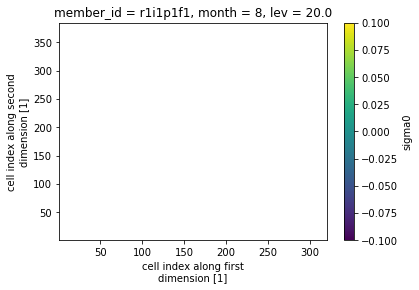

In [6]:
# interpolate density data
for i in dset_dict:
    dsi = (dset_dict[i].sigma0).interp(lev=np.linspace(0,20,21))
    surf_dens = dsi.sel(lev = 20)
#     print(surf_dens)
surf_dens.plot()    

In [40]:

#dset_dict[i].bottom_depth.plot(); plt.show(); plt.close()
#dset_dict[i].bottom_temp.plot(); plt.show(); plt.close()
#dset_dict[i].bottom_sigma2.plot(); plt.show(); plt.close()


In [41]:
#Make depth/lev coordinate uniform in name
if 'depth' in ds:
    ds.depth = xr.Dataset.rename({'depth':'lev'})

# and units
if ds.lev.units == 'centimeters':
    ds.lev.values = ds.lev.values/100

NameError: name 'ds' is not defined

In [ ]:

ds['relative_depth'] = mld/bottom_depth


In [ ]:
def calc_mld(ds):
    # getting time slice and selecting Augusts
    ds = ds.sel(time=slice('1986','2005')).groupby('time.month').mean().sel(month=8)

    # Make depth/lev coordinate uniform in name
    if 'depth' in ds:
        ds.depth = xr.Dataset.rename({'depth':'lev'})

    # and units
    if ds.lev.units == 'centimeters':
        ds.lev.values = ds.lev.values/100

    # calculate potential density using gibbs sea water package
    cthetao = xr.apply_ufunc(gsw.CT_from_pt, ds.so, ds.thetao, dask='parallelized',
                                             output_dtypes=[float,]).rename('cthetao').to_dataset() 

    
    # using sigma0 here to calculate mixed layer depth
    sigma0=xr.apply_ufunc(gsw.density.sigma0,ds.so, ds.cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma0').to_dataset()
    ds = xr.merge([sigma0, ds])
  
   
    
    ds.sigma0.isel(lev=0).plot()
    
    # calculate sigma2
    sigma2=xr.apply_ufunc(gsw.density.sigma2,ds.so, ds.cthetao, dask='parallelized', 
                        output_dtypes=[float, ]).rename('sigma2').to_dataset()
    ds = xr.merge([sigma2, ds])
    
    # Calculate mixed layer depth based on density difference from 10m
    dens_diff = ds.sigma0 - surf_dens
    dens_diff = dens_diff.where(dens_diff > 0.03)
    mld = dens_diff.lev.where(dens_diff==dens_diff.min(['lev'])).max(['lev'])
    
    #dens_diff.isel(lev=0).plot()
    # add mld to dataset
    ds['mld'] = mld
    
    # find depth of bottom
    test = ds.sigma0 + ds.lev
    print(test)
    bottom_depth = ds.lev.where(test == test.max(dim='lev')).max(dim='lev')
    bottom_depth.plot()
    #add to dataset
    ds['bottom_depth'] = bottom_depth
    ds['relative_depth'] = mld/bottom_depth
        
    # find bottom potential density referenced to 2000m and temperature
    bottom_sigma2 = ds.sigma2.where(test == test.max(['lev'])).max(dim='lev')
    print(bottom_sigma2)
    ds['bottom_sigma2'] = bottom_sigma2
    
    bottom_temp = ds.thetao.where(test == test.max(['lev'])).max(dim='lev')
    ds['bottom_temp'] = bottom_temp
    
    print(ds)
    return ds

In [ ]:
for i in dset_dict:
    ds = dset_dict[i]
    newds = calc_mld(ds)

In [ ]:
newds.so.isel(lev=0).plot()

In [ ]:
for i in dset_dict:
    print(dset_dict[i].coords)

In [ ]:
def get_latlon(ds):
    # Deal with diferent names for latitude and longitude coordinates
    if 'latitude' in ds:
        latitude = ds.latitude
        longitude = ds.longitude
    elif 'lat' in ds:
        latitude = ds.lat
        longitude = ds.lon
    else:
        latitude = ds.nav_lat
        longitude = ds.nav_lon
        
    if latitude.ndim==3:
        latitude = np.squeeze(np.array(latitude[0,:,:]))
        longitude = np.squeeze(np.array(longitude[0,:,:]))
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    elif latitude.ndim==2:
        latitude = np.array(latitude)
        longitude = np.array(longitude)
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    else:
        nlat = np.size(latitude)
        nlon = np.size(longitude)
        latitude = np.tile(latitude,(nlon,1)).swapaxes(0,1)
        longitude = np.tile(longitude,(nlat,1))
        
    return latitude, longitude